In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Data Exploration

In [2]:
# load features into features; labels (target label, IDs, x,y coordinates) into info
features = np.loadtxt('./training_data/Features.txt')
info = np.loadtxt('./training_data/Info.txt')
print features.shape, info.shape

(102294, 117) (102294, 11)


In [27]:
# Save only the target variable into labels and change from (-1,1) to (0,1)
labels = info[:,0]
labels[labels == -1] = 0

# Print number of benign and malignant ROIs
num_benign_roi = np.sum(labels == 0)
num_malignant_roi = np.sum(labels == 1)
print "Number of Benign cases =", num_benign_roi
print "Number of Malignant cases =", num_malignant_roi

# Load column 4 into patient_IDs
patient_IDs = np.unique(info[:,4])
print "\nTotal Number of patients =", len(patient_IDs)

# Print number of benign and malignant patients
malignant_patient_IDs = np.unique(info[labels == 1,4])
benign_patient_IDs = np.setdiff1d(patient_IDs, malignant_patient_IDs)
print "Number of Benign patients =", len(benign_patient_IDs)
print "Number of Malignant patients =", len(malignant_patient_IDs)

Number of Benign cases = 101671
Number of Malignant cases = 623

Total Number of patients = 1712
Number of Benign patients = 1594
Number of Malignant patients = 118


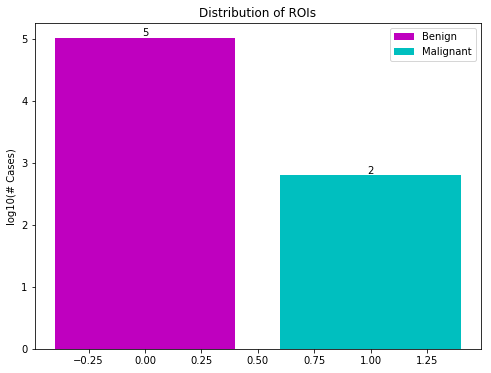

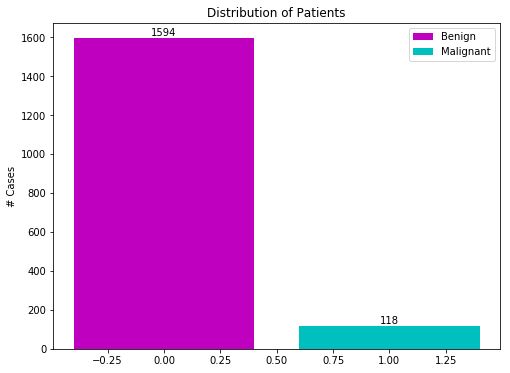

In [28]:
# Reference - Official Docs
# https://matplotlib.org/examples/api/barchart_demo.html
def bar_label(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.001*height,
                '%d' % int(height), ha='center', va='bottom')

# Plot distribution of ROIs
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
b1 = ax.bar(0, np.log10(num_benign_roi), color='m')
b2 = ax.bar(1, np.log10(num_malignant_roi), color='c')
ax.legend((b1[0], b2[0]), ('Benign','Malignant'))
ax.set_ylabel('log10(# Cases)')
ax.set_title('Distribution of ROIs')
bar_label(b1)
bar_label(b2)

# Plot distribution of patients
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
b1 = ax.bar(0, len(benign_patient_IDs), color='m')
b2 = ax.bar(1, len(malignant_patient_IDs), color='c')
ax.legend((b1[0], b2[0]), ('Benign','Malignant'))
ax.set_ylabel('# Cases')
ax.set_title('Distribution of Patients')
bar_label(b1)
bar_label(b2)

## Data Preprocessing

### 1. Append features from info.txt

In [5]:
# Get other features like x,y coordinates from info.txt (i.e., delete label, patient ID, lesion ID)
add_features = np.delete(info,[0,1,2,4],axis=1)
# Concatenate the additional features with existing features into X
X = np.concatenate((features,add_features),axis=1)
print X.shape

(102294, 124)


### 2. Scale parameters

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Try different scaling options to choose best

opt = 'std' # options: maxmin or std or none

if opt == 'std':
    clf = StandardScaler()
    X = clf.fit_transform(X)
elif opt =='maxmin':
    clf = MinMaxScaler()
    X = clf.fit_transform(X)
else:
    print('No scaling required')

### 3. Build train and validation sets

In [7]:
from sklearn.model_selection import train_test_split
test_pct = 0.1
seed = 100

# We can split based on ROIs or based on patients. ROI might not be suitable since we need to get data from different patients
split_level = 'patient' # options: roi or patient

if split_level == 'roi':
    X_train, X_test, y_train, y_test = train_test_split(X,labels,test_size=test_pct,stratify=labels,random_state=seed)
elif split_level == 'patient':
    # Since the dataset is imbalanced, we need a good amount of data from both benign and malignant patients

    # Get the benign IDs to split on. 
    ben_train_IDs, ben_test_IDs = train_test_split(benign_patient_IDs,test_size=test_pct,random_state=seed)
    # Get the malignant IDs to split on.
    mal_train_IDs, mal_test_IDs = train_test_split(malignant_patient_IDs,test_size=test_pct,random_state=seed)
    
    # TRAINING:
    # Get the actual data corresponding to the selected benign patient IDs (1 patient will have multiple records)
    ben_train = []
    for ID in ben_train_IDs:
        rel_rows = np.where(info[:,4] == ID)[0]
        ben_train.extend(X[rel_rows,:])
    # Convert into np array and add a label of 0 to this data since they are all benign ROIs
    ben_train = np.array(ben_train)
    ben_labels = np.zeros((len(ben_train),1))

    # Get the actual data corresponding to the selected malignant patient IDs (1 patient will have multiple records)
    mal_train = []
    for ID in mal_train_IDs:
        rel_rows = np.where(info[:,4] == ID)[0]
        mal_train.extend(X[rel_rows,:])
    # Convert into np array and add a label of 1 to this data since they are all malignant ROIs
    mal_train = np.array(mal_train)
    mal_labels = np.ones((len(mal_train),1))

    # Concatenate both benign and malignant training data to form X_train and both benign and malignant labels to form y_train
    X_train = np.concatenate((ben_train,mal_train),axis=0)
    y_train = np.concatenate((ben_labels,mal_labels),axis=0)

    
    # TESTING:
    # Get the actual data corresponding to the selected benign patient IDs (1 patient will have multiple records)
    ben_test = []
    for ID in ben_test_IDs:
        rel_rows = np.where(info[:,4] == ID)[0]
        ben_test.extend(X[rel_rows,:])
    # Convert into np array and add a label of 0 to this data since they are all benign ROIs
    ben_test = np.array(ben_test)
    ben_labels = np.zeros((len(ben_test),1))

    # Get the actual data corresponding to the selected malignant patient IDs (1 patient will have multiple records)    
    mal_test = []
    for ID in mal_test_IDs:
        rel_rows = np.where(info[:,4] == ID)[0]
        mal_test.extend(X[rel_rows,:])
    # Convert into np array and add a label of 1 to this data since they are all malignant ROIs
    mal_test = np.array(mal_test)
    mal_labels = np.ones((len(mal_test),1))

    # Concatenate both benign and malignant testing data to form X_test and both benign and malignant labels to form y_test
    X_test = np.concatenate((ben_test,mal_test),axis=0)
    y_test = np.concatenate((ben_labels,mal_labels),axis=0)
else:
    print 'Not supported!!'

## Exploratory Visualization

### PCA to visualize the full dataset

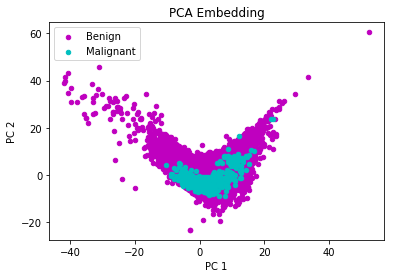

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_2d = pca.fit_transform(X)
plt.figure()
plt.scatter(X_2d[labels==0,0],X_2d[labels==0,1],20,'m',label='Benign')
plt.scatter(X_2d[labels==1,0],X_2d[labels==1,1],20,'c',label='Malignant')
plt.legend(loc='best')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA Embedding')
plt.show()

## Free form visualization

### Dataset Leakage Test -- Predict using Patient ID

In [9]:
ben_labels_leak = np.zeros((len(benign_patient_IDs),1))
mal_labels_leak = np.ones((len(malignant_patient_IDs),1))
leakage_features = np.concatenate((benign_patient_IDs,malignant_patient_IDs))
leakage_features = np.expand_dims(leakage_features,1) # Reshaping
leakage_labels = np.concatenate((ben_labels_leak,mal_labels_leak),axis=0)
print leakage_features.shape, leakage_labels.shape

(1712, 1) (1712, 1)


In [10]:
# Fit a Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
X_leak_train, X_leak_test, y_leak_train, y_leak_test = train_test_split(leakage_features,leakage_labels,test_size=0.3,stratify=leakage_labels,random_state=42)
clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X_leak_train,y_leak_train)
y_leak_pred = clf.predict(X_leak_test)
print accuracy_score(y_leak_test,y_leak_pred)
print confusion_matrix(y_leak_test, y_leak_pred)

0.929961089494
[[470   9]
 [ 27   8]]


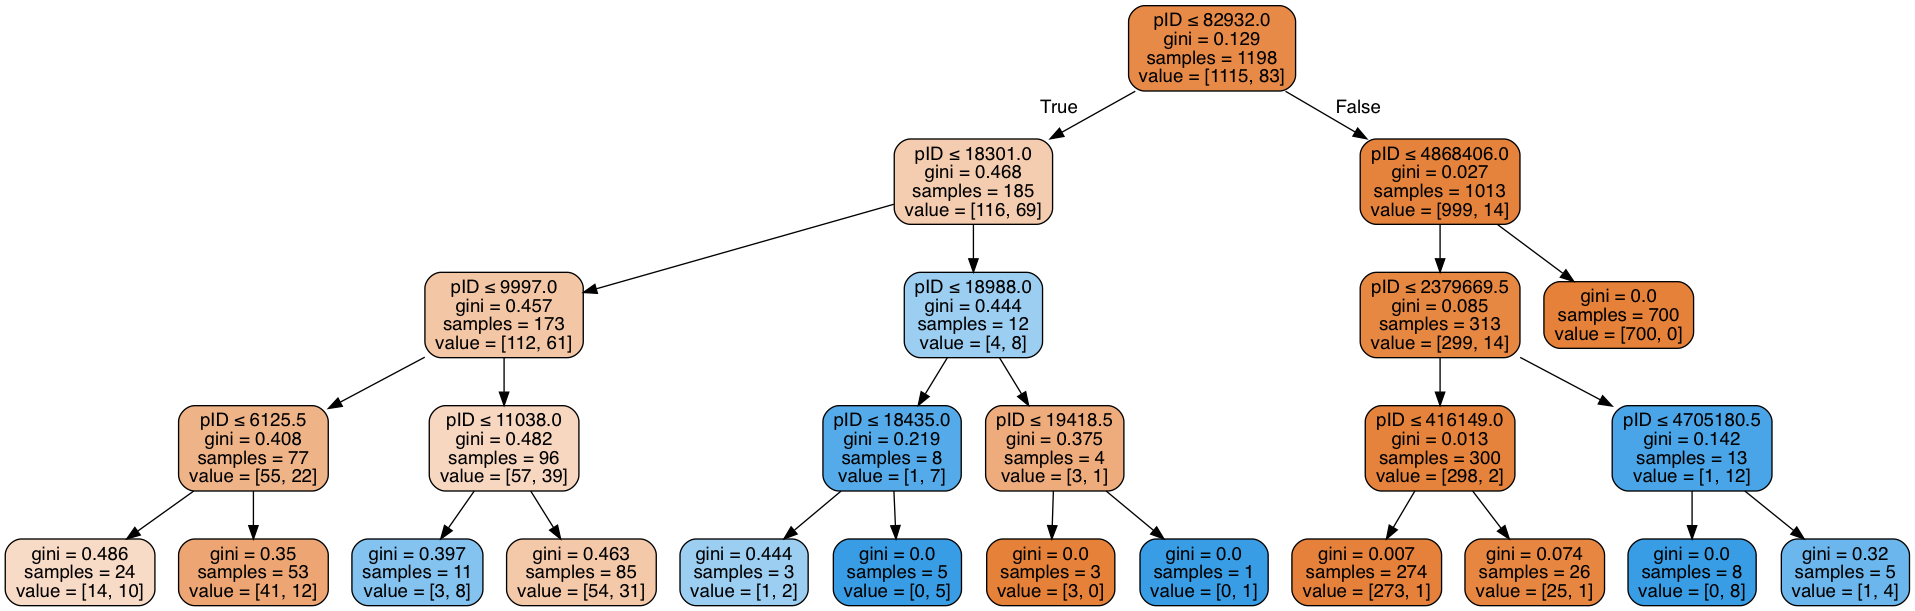

In [11]:
# Visualize Decision Tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

feature_names = ['pID']
dot_data = StringIO()

export_graphviz(clf, feature_names = feature_names, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Build Basic Classification Models:

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import roc_auc_score

In [14]:
# Call each model in a for loop and get results
names = ['Linear SVM', 'Decision Tree', 'Naive Bayes']

classifiers = [
    LinearSVC(random_state=0),
    DecisionTreeClassifier(random_state=0, max_depth=5),
    GaussianNB()]

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train.ravel())
    y_pred = clf.predict(X_test)
    print "Classification Report for %s classifier" %(name)
    print classification_report_imbalanced(y_test, y_pred)
    print 'Macro AUC-ROC = ', roc_auc_score(y_test,y_pred, average='macro')

Classification Report for Linear SVM classifier
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.92      1.00      0.01      0.96      0.09      0.01      9500
        1.0       0.88      0.01      1.00      0.02      0.09      0.01       854

avg / total       0.91      0.92      0.09      0.88      0.09      0.01     10354

Macro AUC-ROC =  0.504045729077
Classification Report for Decision Tree classifier
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.93      0.98      0.23      0.96      0.47      0.24      9500
        1.0       0.48      0.23      0.98      0.31      0.47      0.21       854

avg / total       0.90      0.92      0.29      0.90      0.47      0.24     10354

Macro AUC-ROC =  0.602688401331
Classification Report for Naive Bayes classifier
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.93      0.91  

## Rebuild Decision Tree with Ensemble Models

In [15]:
# Fit Ensemble models on Decision Tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
names = ['Bagging', 'Random Forests', 'Adaboost', 'GBT']

classifiers = [
    BaggingClassifier(n_estimators=10, base_estimator=DecisionTreeClassifier(max_depth=5)),
    RandomForestClassifier(n_estimators=10, max_depth=5),
    AdaBoostClassifier(n_estimators=10, base_estimator=DecisionTreeClassifier(max_depth=5) , algorithm='SAMME'),
    GradientBoostingClassifier(n_estimators=10)]

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train.ravel())
    y_pred = clf.predict(X_test)
    print "Classification Report for %s classifier" %(name)
    print classification_report_imbalanced(y_test, y_pred)
    print 'Macro AUC-ROC = ', roc_auc_score(y_test,y_pred, average='macro')

Classification Report for Bagging classifier
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.93      0.98      0.23      0.96      0.47      0.24      9500
        1.0       0.53      0.23      0.98      0.32      0.47      0.21       854

avg / total       0.90      0.92      0.29      0.90      0.47      0.24     10354

Macro AUC-ROC =  0.605063355109
Classification Report for Random Forests classifier
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.92      1.00      0.02      0.96      0.12      0.02      9500
        1.0       1.00      0.02      1.00      0.03      0.12      0.01       854

avg / total       0.93      0.92      0.10      0.88      0.12      0.02     10354

Macro AUC-ROC =  0.507611241218
Classification Report for Adaboost classifier
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.96      0.99      0

## Resampling for imbalanced data

In [16]:
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.pipeline import make_pipeline

### a. SMOTE with Decision Trees

In [17]:
pipe = make_pipeline(SMOTE(random_state=42), DecisionTreeClassifier(max_depth=5))
pipe.fit(X_train, y_train.ravel())
y_pred = pipe.predict(X_test)
print "Classification Report for SMOTE + Decision Tree classifier"
print classification_report_imbalanced(y_test, y_pred)
print 'Macro AUC-ROC = ', roc_auc_score(y_test,y_pred, average='macro')

Classification Report for SMOTE + Decision Tree classifier
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      0.92      0.84      0.95      0.88      0.78      9500
        1.0       0.50      0.84      0.92      0.62      0.88      0.77       854

avg / total       0.94      0.92      0.85      0.93      0.88      0.78     10354

Macro AUC-ROC =  0.882381239985


### b. SMOTE with Bagging

In [18]:
pipe = make_pipeline(SMOTE(random_state=42), BaggingClassifier(n_estimators=10, base_estimator=DecisionTreeClassifier(max_depth=5)))
pipe.fit(X_train, y_train.ravel())
y_pred = pipe.predict(X_test)
print "Classification Report for SMOTE + Bagging classifier"
print classification_report_imbalanced(y_test, y_pred)
print 'Macro AUC-ROC = ', roc_auc_score(y_test,y_pred, average='macro')

Classification Report for SMOTE + Bagging classifier
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      0.92      0.84      0.95      0.88      0.78      9500
        1.0       0.50      0.84      0.92      0.62      0.88      0.77       854

avg / total       0.94      0.92      0.84      0.93      0.88      0.78     10354

Macro AUC-ROC =  0.879822260569


### c. Balanced Bagging

In [19]:
clf = BalancedBaggingClassifier(n_estimators=10, base_estimator=DecisionTreeClassifier(max_depth=5))
pipe.fit(X_train, y_train.ravel())
y_pred = pipe.predict(X_test)
print "Classification Report for Balanced Bagging classifier"
print classification_report_imbalanced(y_test, y_pred)
print 'Macro AUC-ROC = ', roc_auc_score(y_test,y_pred, average='macro')

Classification Report for Balanced Bagging classifier
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      0.92      0.84      0.95      0.88      0.78      9500
        1.0       0.50      0.84      0.92      0.62      0.88      0.77       854

avg / total       0.94      0.92      0.84      0.93      0.88      0.78     10354

Macro AUC-ROC =  0.879769628991


## Refinement

### 'Super' Ensemble / Stacking

In [25]:
classifiers = [
    DecisionTreeClassifier(random_state=0, max_depth=5),
    make_pipeline(SMOTE(random_state=42), DecisionTreeClassifier(max_depth=5)),
    AdaBoostClassifier(n_estimators=10, base_estimator=DecisionTreeClassifier(max_depth=5) , algorithm='SAMME')]

X_blend_train = np.zeros((X_train.shape[0], len(classifiers))) # shape will be num samples by num classifers
X_blend_test = np.zeros((X_test.shape[0], len(classifiers)))

for j, model in enumerate(classifiers):
    model.fit(X_train, y_train.ravel())
    probs = model.predict_proba(X_train)
    X_blend_train[:,j] = probs[:,1]
    probs = model.predict_proba(X_test)
    X_blend_test[:,j] = probs[:,1]

# Using DecisionTreeClassifier as the combiner algorithm
clf = DecisionTreeClassifier(random_state=0, max_depth=5)
clf.fit(X_blend_train, y_train.ravel())
y_pred = clf.predict(X_blend_test)
print "Classification Report for super ensemble with Decision Tree"
print classification_report_imbalanced(y_test, y_pred)
print 'Macro AUC-ROC = ', roc_auc_score(y_test,y_pred, average='macro')

Classification Report for super ensemble with Decision Tree
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      1.00      0.76      0.99      0.87      0.78      9500
        1.0       0.97      0.76      1.00      0.85      0.87      0.74       854

avg / total       0.98      0.98      0.78      0.98      0.87      0.77     10354

Macro AUC-ROC =  0.879081843954


In [23]:
# Using DecisionTreeClassifier as the combiner algorithm
clf = BalancedBaggingClassifier(n_estimators=10)
clf.fit(X_blend_train, y_train.ravel())
y_pred = clf.predict(X_blend_test)
print "Classification Report for super ensemble with Balanced Bagging"
print classification_report_imbalanced(y_test, y_pred)
print 'Macro AUC-ROC = ', roc_auc_score(y_test,y_pred, average='macro')

Classification Report for super ensemble with Balanced Bagging
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      0.99      0.78      0.99      0.88      0.79      9500
        1.0       0.91      0.78      0.99      0.84      0.88      0.76       854

avg / total       0.97      0.98      0.80      0.97      0.88      0.79     10354

Macro AUC-ROC =  0.885870578085
